# **BiLSTM with character level information**

In [2]:
# import os
# print(f'Current working directory: {os.getcwd()}')
# parent_dir = os.path.dirname(os.getcwd())
# print(f'Parent directory: {parent_dir}')
# os.chdir(parent_dir)
# print(f'Current working directory: {os.getcwd()}')
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload

# # notebook will reload external python modules;
# %autoreload 2 

In [3]:
import tensorflow as tf
from datasets import load_dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizerFast, TFAutoModel

from bilstm_models import *

In [4]:
dataset = load_dataset('conll2003')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# Define label2token and token2label mappings
label2token = {
    'O': 0,
    'B-PER': 1,
    'I-PER': 2,
    'B-ORG': 3,
    'I-ORG': 4,
    'B-LOC': 5,
    'I-LOC': 6,
    'B-MISC': 7,
    'I-MISC': 8,
    '[PAD]': 10 
}
token2label = {token: label for label, token in label2token.items()}


# Process the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels)
tokenized_datasets.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels', 'char_encoded_tokens'])

# check the first example in the dataset
example = tokenized_datasets['train'][0]
input_ids = example['input_ids'].numpy()
sentence = tokenizer.decode(input_ids)
print("Original Sentence:")
print(sentence)
labels = example['labels'].numpy()
print("\nLabels Before Transformation:")
print(labels)
labels = labels[labels != 10]
reconstructed_labels = [token2label[token] for token in labels]
print("\nLabels After Transformation:")
print(reconstructed_labels)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Original Sentence:
[CLS] EU rejects German call to boycott British lamb. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Labels Before Transformation:
[10  3  0  7  0  0  0  7  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10

In [5]:
def prepare_dataset(tokenized_data, shuffle=False, cache=True):
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  column_names = ['input_ids', 'attention_mask', 'labels', 'char_encoded_tokens']
  print(f"\t preparing {tokenized_data} dataset ... ", flush=True)
  dataset = tf.data.Dataset.from_tensor_slices((
      {key: np.array(tokenized_datasets[tokenized_data][key]) for key in column_names},
      np.array(tokenized_datasets[tokenized_data]['labels'])
  ))

  if cache:
      dataset = dataset.cache()
  if shuffle:
      dataset = dataset.shuffle(1000)
  dataset = dataset.batch(32, drop_remainder=True)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

In [6]:

train_dataset = prepare_dataset('train', shuffle=True)
validation_dataset = prepare_dataset('validation')
test_dataset = prepare_dataset('test')

print(f"train dataset size: {len(tokenized_datasets['train'])}")
print(f"validation dataset size: {len(tokenized_datasets['validation'])}")
print(f"test dataset size: {len(tokenized_datasets['test'])}")

print(f"{tokenized_datasets['train'][0].keys()}")

print(f"input_ids shape: {tokenized_datasets['train'][0]['input_ids'].shape}")
# print(tokenized_datasets['train'][0]['input_ids'])

print(f"attention maske shape: {tokenized_datasets['train'][0]['attention_mask'].shape}")
# print(tokenized_datasets['train'][0]['attention_mask'])

print(f"labels shape: {tokenized_datasets['train'][0]['labels'].shape}")
# print(tokenized_datasets['train'][0]['labels'])

print(f"tokenised train dataset shape: {tokenized_datasets['train'][0]['char_encoded_tokens'].shape}")
# print(tokenized_datasets['train'][0]['char_encoded_tokens'])

	 preparing train dataset ... 
	 preparing validation dataset ... 
	 preparing test dataset ... 
train dataset size: 14041
validation dataset size: 3250
test dataset size: 3453
dict_keys(['input_ids', 'attention_mask', 'labels', 'char_encoded_tokens'])
input_ids shape: (128,)
attention maske shape: (128,)
labels shape: (128,)
tokenised train dataset shape: (128, 2)


### character embedding

In [7]:
input_data, labels, sample_weights = prepare_inputs(train_dataset)

# Take one example to showcase
input_ids_example, attention_mask_example, char_embed_example = input_data[0][0], input_data[1][0], input_data[2][0]
labels_example = labels[0]
weights_example = sample_weights[0]

# Decode the input_ids_example back to words  
words = tokenizer.convert_ids_to_tokens(input_ids_example)

# Display the first word, its input_ids, attention_mask, char_embed, label and sample_weight
print(f"Word: {words[0]}")
print(f"Input IDs: {input_ids_example[0]}")
print(f"Attention Mask: {attention_mask_example[0]}")
print(f"Char Embedding: {char_embed_example[0]}")
print(f"Label: {labels_example[0]}")
print(f"Sample Weight: {weights_example[0]}")

x_train, y_train, sample_weights_train = prepare_inputs(train_dataset)
x_test, y_test, sample_weights_test = prepare_inputs(test_dataset)
x_val, y_val, sample_weights_val = prepare_inputs(validation_dataset)

Word: [CLS]
Input IDs: 101
Attention Mask: 1
Char Embedding: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: 10
Sample Weight: 0.0


In [8]:
LOAD_MODEL = False
EPOCHS = 20
BATCH_SIZE = 75
num_chars = len(char2idx) # The number of unique characters
hidden_units = 96  # The number of hidden units for LSTM layers
unique_labels = set([tag for sentence in dataset["train"]["ner_tags"] for tag in sentence])
num_classes = len(unique_labels)+1
word_embedding_dim = 64  # The dimension of word embedding
char_embed_dim = 20  # The dimension of character embedding
vocab_size = len(tokenizer.get_vocab())  # Size of the vocabulary

max_seq_len = 128  # Maximum number of words in a sequence
max_word_len = 128  # Maximum number of characters in a word



In [9]:
# prepare training data
x_train_padded = [pad_sequences(x, maxlen=max_seq_len, padding="post", value=vocab_size) for x in x_train]

# y_train_encoded = [[label + 1 for label in seq] for seq in y_train]  # Shift labels to [1, 10]
y_train_new = pad_sequences(y_train, maxlen=max_seq_len, padding="post", value=10)  # Use 0 for padding

x_val_padded = [pad_sequences(x, maxlen=max_seq_len, padding="post", value=vocab_size) for x in x_val]
# y_val_encoded = [[label + 1 for label in seq] for seq in y_val]
y_val_new = pad_sequences(y_val, maxlen=max_seq_len, padding="post", value=10)  # Use 0 for padding

# only word
x_train_nochar = [x_train_padded[0],x_train_padded[1]]
x_val_nochar = [x_val_padded[0],x_val_padded[1]]

In [10]:

print(f"\n\n \t\t\t creating and training model ... \n\n")

# ----------------- pre trained embedding
# Load DistilBERT
distilbert_model = TFAutoModel.from_pretrained('distilbert-base-uncased')
distilbert_model.trainable = False

# Character embedding
print(f"creating character embedding ... ")
char_input = layers.Input(shape=(max_seq_len, max_word_len), dtype='int32')

char_embed = layers.TimeDistributed(layers.Embedding(num_chars, char_embed_dim, mask_zero=True))(char_input)

char_bilstm = layers.TimeDistributed(layers.Bidirectional(layers.LSTM(hidden_units)))(char_embed)

# Word-level input
print(f"creating word-level input ... ")
word_input = layers.Input(shape=(max_seq_len,), dtype='int32')
attention_mask_input = layers.Input(shape=(max_seq_len,), dtype='int32')


print(f"creating word embedding ... ")
# word_embedding = layers.Embedding(input_dim=vocab_size, output_dim=word_embedding_dim)(word_input)
word_embedding = distilbert_model([word_input, attention_mask_input])[0] # with distilbert

print(f"concatenating word and char-level information ... ")
combined = layers.Concatenate()([word_embedding, char_bilstm])

print(f"final BiLSTM layer for sequence tagging ... ")
bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_sequences=True))(combined)

# for word embedding only
# bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_sequences=True,
#                                           kernel_initializer='he_normal'))(word_embedding)

# Final BiLSTM layer for sequence tagging
dropout = layers.Dropout(0.5)(bilstm)
output = layers.TimeDistributed(layers.Dense(num_classes+1, activation='softmax',
                                             kernel_initializer='he_normal'))(dropout)


model = tf.keras.Model(inputs=[word_input, attention_mask_input, char_input], outputs=output) # char info
# model = tf.keras.Model(inputs=[word_input, attention_mask_input], outputs=output) #no char info

class_weights = {i: 1 for i in range(num_classes)}
class_weights[10] = 0  # Set the weight for the padding label to 0

loss_fn = keras.losses.SparseCategoricalCrossentropy()

print(f"COMPILING MODEL ... ")

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss = loss_fn)

if LOAD_MODEL == True:
  model.load_weights('./models/checkpoints/bilstm_checkpoint_model.h5')
else:
  checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss',
                             verbose=1, save_best_only=True, mode='min',
                             save_weights_only=True)



print(f"TRAINING MODEL ... ")
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# get maximum workers from cpu
import multiprocessing
USE_MP = True
workers = multiprocessing.cpu_count()

if USE_MP == True:
  history = model.fit(x_train_padded, y_train_new,
                      validation_data = (x_val_padded,y_val_new),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks = [checkpoint, early_stopping], 
                      use_multiprocessing=True, workers=workers-1)
else:
  history = model.fit(x_train_padded, y_train_new,
                      validation_data = (x_val_padded,y_val_new),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks = [checkpoint, early_stopping])

  
  
# history = model.fit(x_train_nochar, y_train,
#                     validation_data = (x_val_nochar,y_val),
#                     epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks = [checkpoint, early_stopping])




 			 creating and training model ... 




Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


creating character embedding ... 
creating word-level input ... 
creating word embedding ... 
concatenating word and char-level information ... 
final BiLSTM layer for sequence tagging ... 
COMPILING MODEL ... 
TRAINING MODEL ... 
Epoch 1/20
187/187 [==============================] - ETA: 0s - loss: 1.0671
Epoch 1: val_loss improved from inf to 0.93955, saving model to model_checkpoint.h5
187/187 [==============================] - 158s 720ms/step - loss: 1.0671 - val_loss: 0.9395
Epoch 2/20
187/187 [==============================] - ETA: 0s - loss: 0.7917
Epoch 2: val_loss improved from 0.93955 to 0.70491, saving model to model_checkpoint.h5
187/187 [==============================] - 127s 678ms/step - loss: 0.7917 - val_loss: 0.7049
Epoch 3/20
187/187 [==============================] - ETA: 0s - loss: 0.6664
Epoch 3: val_loss improved from 0.70491 to 0.62155, saving model to model_checkpoint.h5
187/187 [==============================] - 127s 680ms/step - loss: 0.6664 - val_loss: 0.6215

In [11]:
# Save the final model
model.save('./bilstm_final_model.h5')

### Testing

In [12]:
x_test_padded = [pad_sequences(x, maxlen=max_seq_len, padding="post", value=vocab_size) for x in x_test]
y_test_new = pad_sequences(y_test, maxlen=max_seq_len, padding="post", value=10)  
x_test_nochar = [x_test_padded[0],x_test_padded[1]]


In [13]:
evaluate_model(model, x_test_padded, y_test_new)

107/107 [==============================] - 16s 105ms/step
              precision    recall  f1-score   support

       B-LOC       0.70      0.56      0.62      2985
      B-MISC       0.50      0.38      0.43      1246
       B-ORG       0.66      0.61      0.63      3479
       B-PER       0.66      0.69      0.67      2974
       I-LOC       0.73      0.32      0.44       413
      I-MISC       0.31      0.25      0.28       319
       I-ORG       0.53      0.58      0.55      1295
       I-PER       0.80      0.88      0.84      2702
           O       0.96      0.97      0.96     47529

    accuracy                           0.89     62942
   macro avg       0.65      0.58      0.60     62942
weighted avg       0.88      0.89      0.89     62942



### Plotting

KeyError: ignored

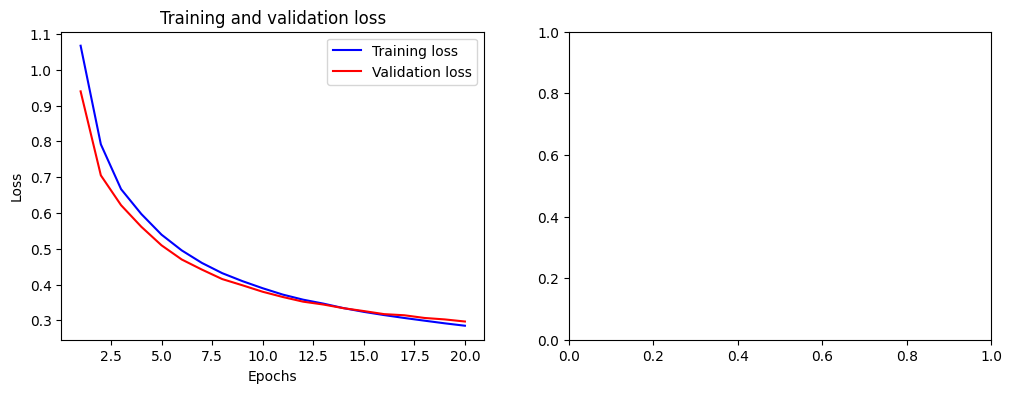

In [15]:
plot_training(history,crf_model=False)